# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
!pip install category_encoders
from category_encoders import TargetEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [5]:
try: 
    auto_df = pd.read_csv('/datasets/autos.csv')
except: 
    auto_df = pd.read_csv(r"C:\Users\QWE\Documents\Проекты для GitHub\10. Построение модели определения стоимости автомобиля\autos.csv")

In [6]:
display(auto_df.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [7]:
print(auto_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
print('Количество дубликатов:', sum(auto_df.duplicated()))

Количество дубликатов: 4


In [9]:
print('Количество пропусков', auto_df.isna().sum())

Количество пропусков DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [10]:
auto_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div class="alert alert-block alert-warning"> Анализ данных:

1. Столбец "Цена" содержит записи с минимальной ценой 0, что может указывать на отсутствие или ошибку в данных.

2. В столбце "RegistrationYear" присутствуют некорректные значения года регистрации.

3. Столбец "Power" содержит некорректные значения мощности двигателя.

4. Более 50% значений в столбце "Kilometer" равны 150000, что может быть ограничением в заявке. Однако, разница между 150000 и 300000 существенна и должна влиять на стоимость автомобиля.

5. В столбце "RegistrationMonth" отсутствуют значения месяца регистрации.

Признаки, значимые для модели:

- "VehicleType": тип машины, который определяет ее функциональность и возможности. 
- "RegistrationYear": год регистрации машины, который определяет ее "свежесть". Чем старше автомобиль, тем ниже его цена.

- "Gearbox": наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.

- "Power": мощность двигателя в лошадиных силах, которая напрямую влияет на цену автомобиля.

- "Model": в совокупности с типом машины и брендом может влиять на популярность у потенциальных покупателей.

- "Kilometer": пробег автомобиля, чем больше пробег, тем ниже его надежность и, соответственно, цена.

- "FuelType": тип топлива, который определяет конструкцию двигателя внутреннего сгорания.

- "Brand": компания-производитель автомобиля, которая отражает его качество и надежность.

- "Repaired": указывает, была ли машина в аварии. Если машина побывала в ДТП, ее конструкция могла быть изменена, что снижает надежность и влияет на цену. </div>

<div class="alert alert-block alert-warning"> Создадим новый набор данных на основе вывода

In [11]:
filtred_auto_df = auto_df[['VehicleType', 
                         'RegistrationYear',
                         'Gearbox', 
                         'Power',
                         'Model',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'Price']]
filtred_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  354369 non-null  int64 
 2   Gearbox           334536 non-null  object
 3   Power             354369 non-null  int64 
 4   Model             334664 non-null  object
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   Repaired          283215 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [12]:
filtred_auto_df.duplicated().sum()

45040

In [13]:
filtred_auto_df = filtred_auto_df.drop_duplicates()
filtred_auto_df.duplicated().sum()

0

<div class="alert alert-block alert-warning"> Построим гистограмму по столбцу Price </div>

<Axes: >

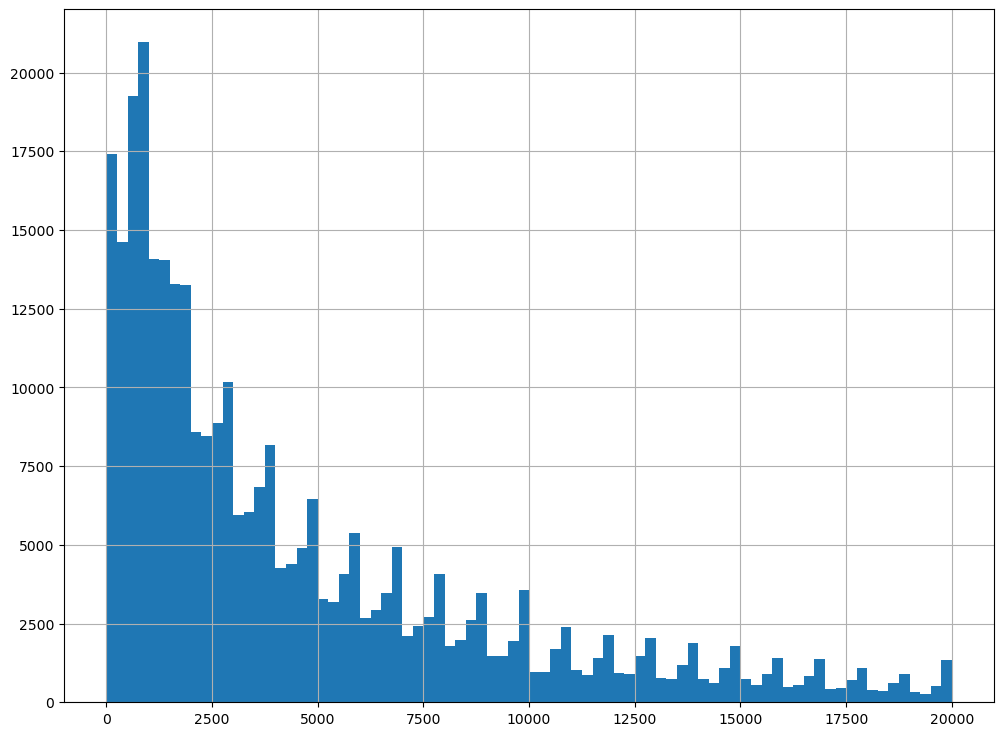

In [14]:
filtred_auto_df['Price'].hist(bins=80, figsize=(12,9))

In [15]:
filtred_auto_df['Price'].value_counts()

Price
0        8904
500      4650
1500     4533
1000     3875
1200     3799
         ... 
477         1
12560       1
15445       1
132         1
10985       1
Name: count, Length: 3731, dtype: int64

count    300425.000000
mean       4619.921098
std        4565.205287
min           1.000000
25%        1200.000000
50%        2900.000000
75%        6650.000000
max       20000.000000
Name: Price, dtype: float64

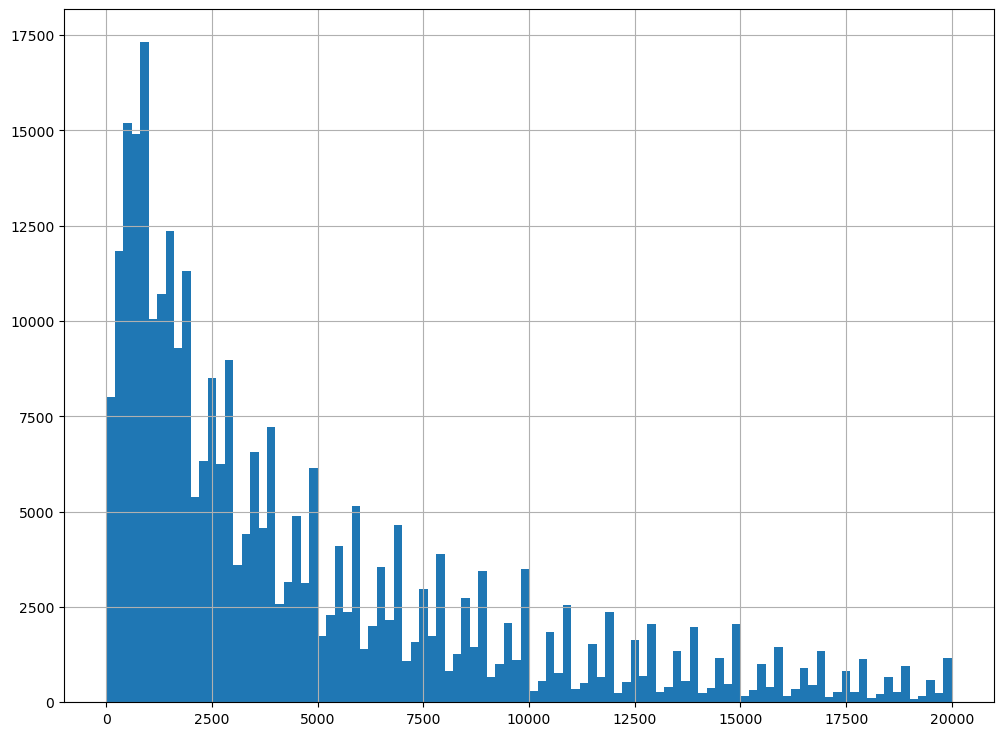

In [16]:
filtred_auto_df = filtred_auto_df.query('Price > 0')
filtred_auto_df['Price'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Price'].describe()

In [17]:
filtred_auto_df['Price'].quantile([0.2, 0.88])

0.20      990.0
0.88    10750.0
Name: Price, dtype: float64

<div class="alert alert-block alert-warning"> Цена в размере 990 евро примерно эквивалентна 80000 рублей. За такую сумму обычно можно приобрести автомобиль. Выбор 88-го процентиля обоснован наличием значительных выбросов после отметки в 10000 евро. Гистограмма показывает, что значения после этой отметки не сильно отличаются друг от друга. </div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

(Отвлечение ... что-то менять не надо) Мне это напомнило один известный фильм, где автомобиль за 500 долларов был способен доехать до Сан-Франциско и обратно ))))
</div>

In [18]:
filtred_auto_df = filtred_auto_df.query('990 <= Price <= 10500')
filtred_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204267 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       185868 non-null  object
 1   RegistrationYear  204267 non-null  int64 
 2   Gearbox           195894 non-null  object
 3   Power             204267 non-null  int64 
 4   Model             194352 non-null  object
 5   Kilometer         204267 non-null  int64 
 6   FuelType          188344 non-null  object
 7   Brand             204267 non-null  object
 8   Repaired          167863 non-null  object
 9   Price             204267 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 17.1+ MB


<div class="alert alert-block alert-warning"> Рассмотрим год регистрации авто RegistrationYear </div> 

count    204267.000000
mean       2003.978322
std          58.632683
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

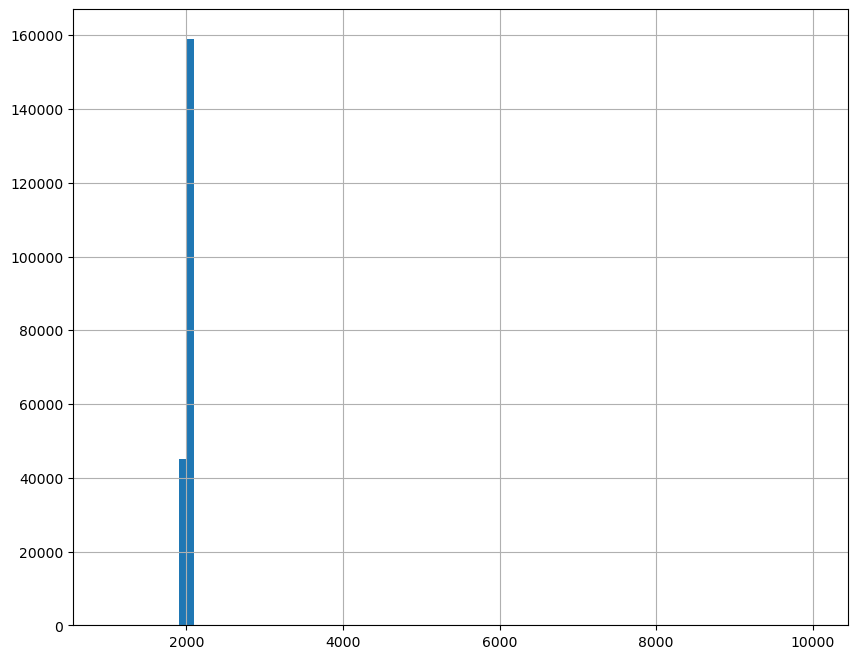

In [19]:
filtred_auto_df['RegistrationYear'].hist(bins=90, figsize=(10,8))
filtred_auto_df['RegistrationYear'].describe()

In [20]:
car_date_max = pd.to_datetime(auto_df['DateCrawled'])
car_date_max.max()

Timestamp('2016-04-07 14:36:58')

In [21]:
car_date_min = pd.to_datetime(auto_df['RegistrationYear'])
car_date_min.min()

Timestamp('1970-01-01 00:00:00.000001')

count    194020.000000
mean       2002.891434
std           5.903556
min        1971.000000
25%        2000.000000
50%        2003.000000
75%        2006.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

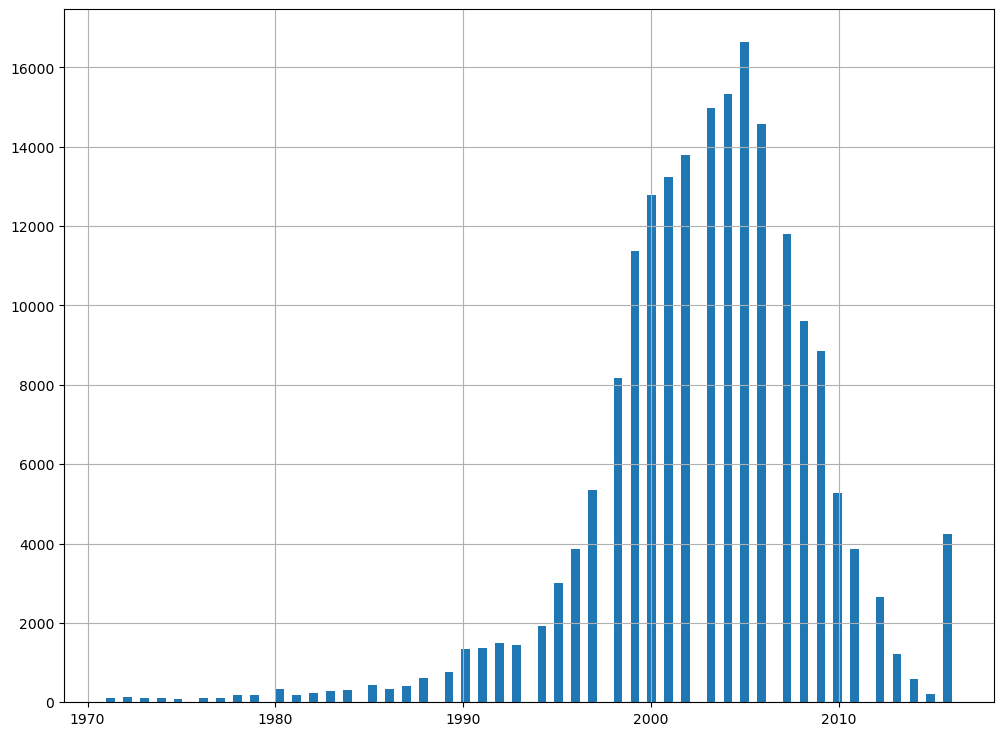

In [22]:
filtred_auto_df = filtred_auto_df.query('1970 < RegistrationYear < 2017')
filtred_auto_df['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_auto_df['RegistrationYear'].describe()

<div class="alert alert-block alert-warning"> Некорректными являются даты регистрации, которые находятся после 2016 года и до 1970 года. Мы исключим эти неправильные годы и построим график.

Затем займемся заменой данных в столбцах "Gearbox", "Repaired" и "Model".

In [23]:
filtred_auto_df.fillna({'Gearbox':'manual', 'Repaired':'yes', 'Model':'unknown'},
                          inplace=True)
filtred_auto_df.isna().mean()

VehicleType         0.045428
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.062524
Brand               0.000000
Repaired            0.000000
Price               0.000000
dtype: float64

In [24]:
# Давайте проанализируем количество пропущенных значений в столбце "VehicleType" относительно общего числа значений в этом столбце.
display(filtred_auto_df['VehicleType'].value_counts())
display(filtred_auto_df['VehicleType'].isna().sum())

VehicleType
sedan          53800
small          43058
wagon          38566
bus            19914
convertible    12706
coupe           8966
suv             6169
other           2027
Name: count, dtype: int64

8814

In [25]:
#Для наглядного представления количества марок, моделей и типов кузова, 
#построим сводную таблицу, которая позволит нам увидеть разбиение по этим категориям и количество автомобилей, 
#соответствующих каждой комбинации марки, модели и типа кузова.
vehicle_type_pvt = filtred_auto_df.pivot_table(index=['VehicleType'], 
                                                    columns=['Brand'],
                                                    values=['Price'],
                                                    aggfunc=['count'])
display(vehicle_type_pvt)

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      5.0      98.0    269.0   994.0   33.0   
convertible      119.0   885.0   1915.0       8.0    170.0    93.0    NaN   
coupe            174.0   658.0   2036.0      49.0     30.0   102.0    NaN   
other              5.0    67.0    139.0      21.0      6.0    75.0    5.0   
sedan            571.0  6253.0  10324.0     166.0    158.0   448.0   88.0   
small            177.0   750.0    251.0     505.0      8.0  1105.0  190.0   
suv                NaN    14.0    315.0     231.0     13.0    10.0  142.0   
wagon            305.0  6262.0   4726.0      82.0    174.0   385.0  221.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           18.0     19.0   623.0  ...   466.0   183.0     1.0   
convertible    NaN     15.0   291.0  ...     NaN     2.0   988.0   
coupe          1.0      NaN   119.0  ...    48.0     5.0   284.0   
other          3.0      5.0   123.0  ...    32.0    19.0     7.0   
sedan         44.0     31.0   541.0  ...  1142.0   654.0    24.0   
small        139.0    245.0  2842.0  ...  1874.0   856.0  2687.0   
suv            1.0     29.0    17.0  ...     3.0    22.0     NaN   
wagon         19.0     14.0   232.0  ...   183.0  1807.0     1.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  145.0   12.0   19.0   373.0     NaN     6123.0     NaN  
convertible          180.0    1.0   28.0    55.0    28.0     1822.0    36.0  
coupe                 74.0    3.0    NaN   146.0     2.0      705.0    42.0  
other                131.0    4.0   10.0    13.0     5.0      503.0     2.0  
sedan                231.0   94.0   99.0   696.0    91.0    11009.0   410.0  
small                136.0   52.0  610.0  1254.0    28.0     9352.0     7.0  
suv                  223.0   42.0  586.0   318.0     NaN      367.0    65.0  
wagon                 90.0  175.0   53.0   430.0    40.0     7532.0  1158.0  

[8 rows x 40 columns]

In [26]:
vehicle_type_pvt = vehicle_type_pvt['count']['Price']
vehicle_type_pvt

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,5.0,98.0,269.0,994.0,33.0,18.0,19.0,623.0,...,466.0,183.0,1.0,145.0,12.0,19.0,373.0,NaN,6123.0,NaN
convertible,119.0,885.0,1915.0,8.0,170.0,93.0,NaN,NaN,15.0,291.0,...,NaN,2.0,988.0,180.0,1.0,28.0,55.0,28.0,1822.0,36.0
coupe,174.0,658.0,2036.0,49.0,30.0,102.0,NaN,1.0,NaN,119.0,...,48.0,5.0,284.0,74.0,3.0,NaN,146.0,2.0,705.0,42.0
other,5.0,67.0,139.0,21.0,6.0,75.0,5.0,3.0,5.0,123.0,...,32.0,19.0,7.0,131.0,4.0,10.0,13.0,5.0,503.0,2.0
sedan,571.0,6253.0,10324.0,166.0,158.0,448.0,88.0,44.0,31.0,541.0,...,1142.0,654.0,24.0,231.0,94.0,99.0,696.0,91.0,11009.0,410.0
small,177.0,750.0,251.0,505.0,8.0,1105.0,190.0,139.0,245.0,2842.0,...,1874.0,856.0,2687.0,136.0,52.0,610.0,1254.0,28.0,9352.0,7.0
suv,NaN,14.0,315.0,231.0,13.0,10.0,142.0,1.0,29.0,17.0,...,3.0,22.0,NaN,223.0,42.0,586.0,318.0,NaN,367.0,65.0
wagon,305.0,6262.0,4726.0,82.0,174.0,385.0,221.0,19.0,14.0,232.0,...,183.0,1807.0,1.0,90.0,175.0,53.0,430.0,40.0,7532.0,1158.0


In [27]:
filtred_auto_df['VehicleType'] = filtred_auto_df['VehicleType'].fillna(filtred_auto_df.groupby(by=['Brand', 'Model'])['VehicleType'].transform(lambda x: x.value_counts().idxmax()))


**V4** Обновил! Спасибо!  

In [28]:
filtred_auto_df.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price
2,suv,2004,auto,163,grand,125000,gasoline,jeep,yes,9800
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2200
9,small,1998,manual,101,golf,150000,NaN,volkswagen,yes,999


In [29]:
# Заполним пустые значения нулями для всех столбцов
filtred_auto_df.fillna(0, inplace=True)

# Создадим функцию, которая будет заменять пропущенные значения в столбце типа топлива
# на наиболее распространенный тип для каждой марки автомобиля.
def fillna_by_brand(row, fuel_type_pvt):
    brand = row['Brand']
    fill_value = row['FuelType']
    if fill_value == 0 and brand in fuel_type_pvt.index:
        fill_value = fuel_type_pvt.loc[brand].idxmax()
    return fill_value

# Получим таблицу сводной для типа топлива
fuel_type_pvt = filtred_auto_df.pivot_table(index='Brand',
                                            columns='FuelType',
                                            values='Price',
                                            aggfunc='count')

# Применим функцию
filtred_auto_df['FuelType'] = filtred_auto_df.apply(
    lambda row: fillna_by_brand(row, fuel_type_pvt),
    axis=1
)

# Проверим, сколько осталось пропущенных значений
display(filtred_auto_df['FuelType'].isna().sum())

# Выведем количество значений для каждого типа топлива
filtred_auto_df['FuelType'].value_counts()


0

FuelType
petrol      130346
gasoline     59233
lpg           3794
cng            426
hybrid          91
other           72
electric        58
Name: count, dtype: int64

In [30]:
display(filtred_auto_df['FuelType'].isna().sum())
filtred_auto_df['FuelType'].value_counts()

0

FuelType
petrol      130346
gasoline     59233
lpg           3794
cng            426
hybrid          91
other           72
electric        58
Name: count, dtype: int64

In [31]:
filtred_auto_df.isna().mean()

VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
Price               0.0
dtype: float64

count    194020.000000
mean        113.953031
std         194.775691
min           0.000000
25%          75.000000
50%         109.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

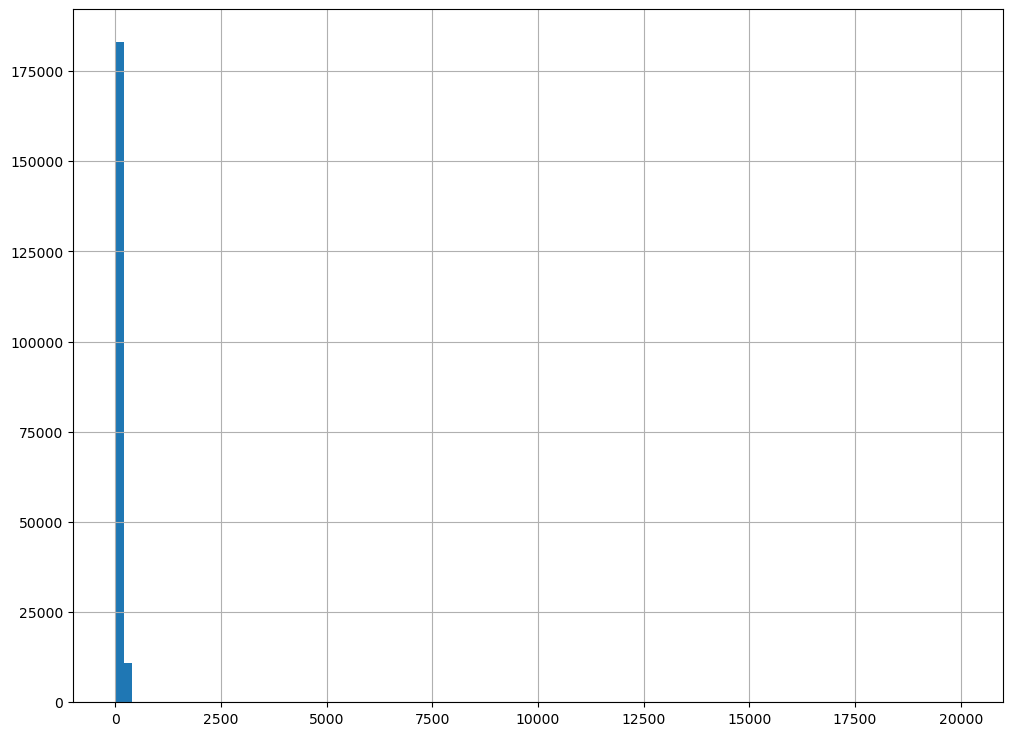

In [32]:
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()

count    193845.000000
mean        110.338121
std          57.304278
min           0.000000
25%          75.000000
50%         109.000000
75%         143.000000
max        1000.000000
Name: Power, dtype: float64

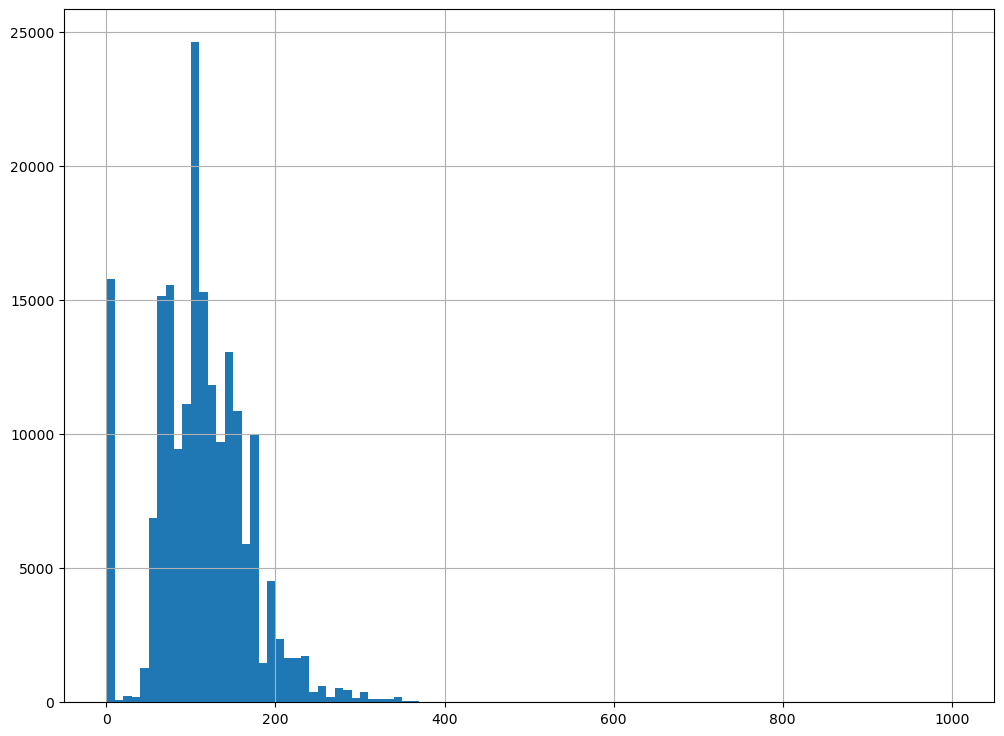

In [33]:
filtred_auto_df = filtred_auto_df.query('Power < 1001')
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()

count    178144.000000
mean        119.800386
std          47.916850
min           1.000000
25%          83.000000
50%         114.000000
75%         146.000000
max         449.000000
Name: Power, dtype: float64

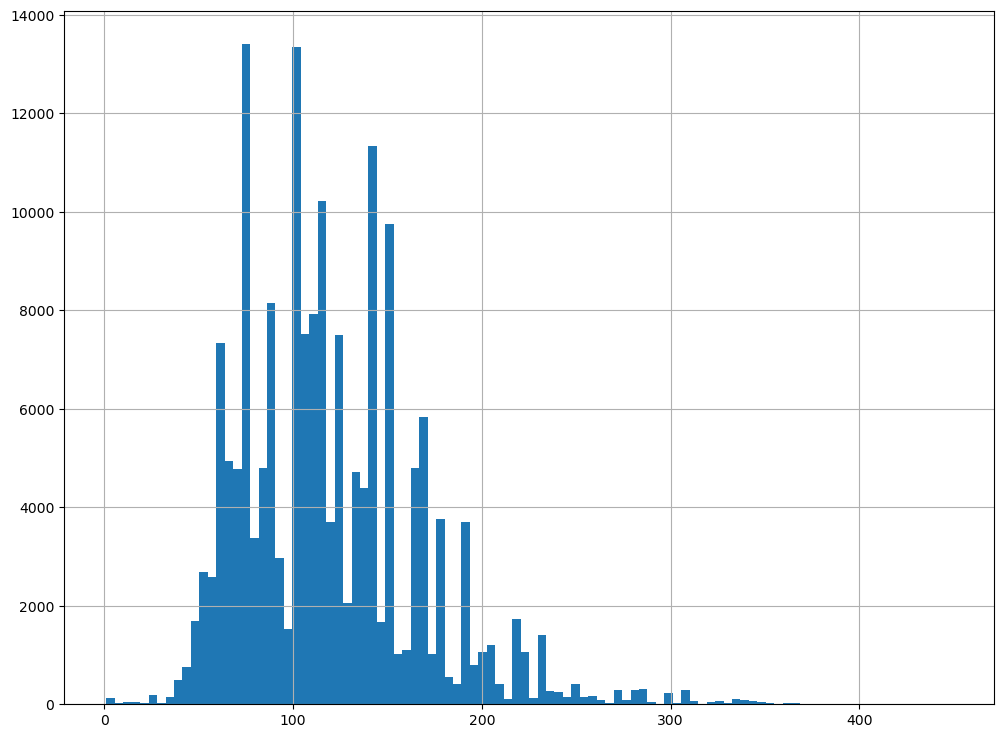

In [34]:
# Справа подобрали значение в 450 л.с.
filtred_auto_df = filtred_auto_df.query('0 < Power < 450')
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()

In [35]:
good_auto_df = filtred_auto_df
good_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178144 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       178144 non-null  object
 1   RegistrationYear  178144 non-null  int64 
 2   Gearbox           178144 non-null  object
 3   Power             178144 non-null  int64 
 4   Model             178144 non-null  object
 5   Kilometer         178144 non-null  int64 
 6   FuelType          178144 non-null  object
 7   Brand             178144 non-null  object
 8   Repaired          178144 non-null  object
 9   Price             178144 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 15.0+ MB


In [36]:
# Добавим столбец 'Is_manual_gearbox', где 1 - это manual, 0 - это auto
good_auto_df['Is_manual_gearbox'] = 0
good_auto_df.loc[good_auto_df['Gearbox'] == 'manual', 'Is_manual_gearbox'] = 1
display(good_auto_df['Is_manual_gearbox'].value_counts())
good_auto_df['Gearbox'].value_counts()

Is_manual_gearbox
1    143491
0     34653
Name: count, dtype: int64

Gearbox
manual    143491
auto       34653
Name: count, dtype: int64

In [37]:
# Добавим столбец 'Was_not_repaired', где 1 - это машина не ремонтировалась, 0 - машина с ремонтом
good_auto_df['Was_not_repaired'] = 0
good_auto_df.loc[good_auto_df['Repaired'] == 'yes', 'Was_not_repaired'] = 1
display(good_auto_df['Was_not_repaired'].value_counts())
good_auto_df['Repaired'].value_counts()

Was_not_repaired
0    139318
1     38826
Name: count, dtype: int64

Repaired
no     139318
yes     38826
Name: count, dtype: int64

In [38]:
good_auto_df.drop(['Repaired','Gearbox'], inplace=True, axis=1)
good_auto_df['Was_not_repaired'] = pd.to_numeric(good_auto_df['Was_not_repaired'], downcast='integer')
good_auto_df['Is_manual_gearbox'] = pd.to_numeric(good_auto_df['Is_manual_gearbox'], downcast='integer')
good_auto_df['RegistrationYear'] = pd.to_numeric(good_auto_df['RegistrationYear'], downcast='integer')
good_auto_df['Power'] = pd.to_numeric(good_auto_df['Power'], downcast='integer')
good_auto_df['Kilometer'] = pd.to_numeric(good_auto_df['Kilometer'], downcast='integer')
good_auto_df['Price'] = pd.to_numeric(good_auto_df['Price'], downcast='integer')
good_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178144 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        178144 non-null  object
 1   RegistrationYear   178144 non-null  int16 
 2   Power              178144 non-null  int16 
 3   Model              178144 non-null  object
 4   Kilometer          178144 non-null  int32 
 5   FuelType           178144 non-null  object
 6   Brand              178144 non-null  object
 7   Price              178144 non-null  int16 
 8   Is_manual_gearbox  178144 non-null  int8  
 9   Was_not_repaired   178144 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 8.8+ MB


In [39]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 10.2/43.3))

Уменьшение использования памяти на 76.44%


<div class="alert alert-block alert-warning">  В результате анализа данных были выполнены следующие действия:

1. Обработаны пропущенные значения, аномалии и некорректные значения в данных.

2. Определены необходимые столбцы, которые будут использоваться для обучения модели.

3. Произведена замена категориальных признаков на числовые, чтобы они могли быть использованы в модели.

4. Была проведена оптимизация датафрейма, что привело к сокращению потребления памяти на 76%.

Таким образом, данные были подготовлены для дальнейшего анализа и обучения модели с использованием оптимизированного датафрейма. </div> 

## Обучение моделей

<div class="alert alert-block alert-warning">  Для проведения кросс-валидации подготовим три типа признаков:

1. Неизмененные признаки, которые останутся в исходном виде. Они будут называться "original_features".

2. Признаки, закодированные с использованием метода One-Hot Encoding (OHE), где каждая категория будет преобразована в бинарные столбцы. Эти признаки будут называться "ohe_features".

3. Признаки, закодированные с использованием метода Ordinal Encoding (OE), где каждая категория будет преобразована в числовое значение. Эти признаки будут называться "ordinal_features".

Таким образом, мы создадим три набора признаков, которые будут использоваться для кросс-валидации и обучения модели.</div> 

In [41]:
original_features = good_auto_df.drop('Price', axis=1)

#Целевой признак
target = good_auto_df['Price']

In [42]:
good_auto_df.shape

(178144, 10)

In [43]:
good_auto_df.head(5)

,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,Price,Is_manual_gearbox,Was_not_repaired
2,suv,2004,163,grand,125000,gasoline,jeep,9800,0,1
3,small,2001,75,golf,150000,petrol,volkswagen,1500,1,0
4,small,2008,69,fabia,90000,gasoline,skoda,3600,1,0
6,convertible,2004,109,2_reihe,150000,petrol,peugeot,2200,1,0
9,small,1998,101,golf,150000,petrol,volkswagen,999,1,1


In [44]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=1515)

In [45]:
good_auto_df.columns.values.tolist ()

['VehicleType',
 'RegistrationYear',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Price',
 'Is_manual_gearbox',
 'Was_not_repaired']

In [46]:
good_auto_df.dtypes

VehicleType          object
RegistrationYear      int16
Power                 int16
Model                object
Kilometer             int32
FuelType             object
Brand                object
Price                 int16
Is_manual_gearbox      int8
Was_not_repaired       int8
dtype: object

In [47]:
auto_df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

In [48]:
encoder = TargetEncoder(cols=['Brand','Model'])  

features_train_encoded = encoder.fit_transform(original_features_train, target_train)
features_test_encoded = encoder.transform(original_features_test)

#OHE к категориальным признакам  
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

ohe_features_train = ohe.fit_transform(features_train_encoded.select_dtypes(include='object'))
ohe_features_test = ohe.transform(features_test_encoded.select_dtypes(include='object'))

features_train_final = np.concatenate([ohe_features_train, original_features_train.select_dtypes(include='int')], axis=1)
features_test_final = np.concatenate([ohe_features_test, original_features_test.select_dtypes(include='int')], axis=1)

print(features_train_final.shape)
print(features_test_final.shape)

(133608, 15)
(44536, 15)


In [49]:
display(features_train_encoded.head(5))

,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,Is_manual_gearbox,Was_not_repaired
289043,sedan,2004,192,4748.965037,150000,petrol,4848.798739,1,0
22368,bus,2004,75,3559.867876,150000,petrol,3801.388220,1,1
57682,bus,2006,105,5800.155853,150000,gasoline,4243.797164,1,0
7804,sedan,2007,105,4148.616761,150000,gasoline,4243.797164,1,0
190381,sedan,1991,179,5199.078873,150000,petrol,4458.007935,0,0


In [50]:
display(features_test_encoded.head(5))

,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,Is_manual_gearbox,Was_not_repaired
151485,coupe,2002,116,6695.494460,150000,petrol,6552.178103,1,0
31142,bus,2003,180,3634.741949,150000,gasoline,4243.797164,1,1
65028,sedan,2006,122,4512.061720,150000,gasoline,4458.007935,1,0
224740,sedan,2006,115,4204.321341,125000,petrol,4243.797164,0,0
85714,convertible,2009,120,3511.126827,60000,petrol,3518.942656,0,0


In [51]:
good_auto_df.head(5)

,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,Price,Is_manual_gearbox,Was_not_repaired
2,suv,2004,163,grand,125000,gasoline,jeep,9800,0,1
3,small,2001,75,golf,150000,petrol,volkswagen,1500,1,0
4,small,2008,69,fabia,90000,gasoline,skoda,3600,1,0
6,convertible,2004,109,2_reihe,150000,petrol,peugeot,2200,1,0
9,small,1998,101,golf,150000,petrol,volkswagen,999,1,1


**V4** Масштабирование признаков 

In [52]:

# Создание StandardScaler
scaler = StandardScaler()

# Масштабирование признаков
scaled_features_train = scaler.fit_transform(features_train_final)
scaled_features_test = scaler.transform(features_test_final)



**Линейная регрессия**

In [53]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             scaled_features_train , 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2508.8179721404786
CPU times: total: 750 ms
Wall time: 202 ms


**v2** Добавил выше

**V4** Исправил

In [54]:
%%time

# Попробуем с масштабируемыми признаками StandardScaler
regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                scaled_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2508.8476302091776
CPU times: total: 1.52 s
Wall time: 319 ms


In [86]:
%%time

# Попробуем с масштабируемыми признаками RobustScaler
regressor = LinearRegression()
scaller = RobustScaler()
pipeline = Pipeline([("robust_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                scaled_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2508.7986390839797
CPU times: total: 1.66 s
Wall time: 394 ms


<div class="alert alert-block alert-warning"> 
Вывод: При применении масштабирования к признакам модель показывает результаты хуже. </div>

**DecisionTree регрессия**

In [87]:
%%time

# Модель на масштабированных признаках 


regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(scaled_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_scaled = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error



ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of DecisionTreeRegressor must be a str among {'friedman_mse', 'squared_error', 'poisson', 'absolute_error'}. Got 'mse' instead.


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V3</b> 	

Здесь данные в которых всего 3 столбца (сравни rmse с rmse ниже).
</div>

In [57]:
%%time

# Модель на закодированных признаках 


regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_final, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_TE = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error



ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\QWE\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of DecisionTreeRegressor must be a str among {'friedman_mse', 'squared_error', 'poisson', 'absolute_error'}. Got 'mse' instead.


Регрессия CatBoostRegressor

In [88]:
%%time

# Модель на закодированных данных 

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[1515],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_final, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error



KeyboardInterrupt: 

In [59]:
%%time

# Модель на оригинальных данных с указанием категорий


regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 100,
                              random_state=1515, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 1226.5132901671284
CPU times: total: 20 s
Wall time: 34.4 s


**V3 LGBM регрессия считалась последний раз 2.5 часа, я так и не понял что поошло не так, может Юпитер сбоил ночью**

Регрессия LGBM

In [60]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_final, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 106886, number of used features: 15
[LightGBM] [Info] Start training from score 4153.202562
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 106886, number of used features: 15
[LightGBM] [Info] Start training from score 4152.860309
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `for

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 se

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 106886, number of used features: 15
[LightGBM] [Info] Start training from score 4153.202562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 133608, number of used features: 15
[LightGBM] [Info] Start training from score 4153.827406
Best parameters set found on development set:

{'learning_rate': 0.3, 'num_leaves': 11, 'random_state': 1515}

Grid scores on development set:

2505.031710 for {'learning_rate': 0.3, 'num_leaves': 11, 'random_state': 1515}
2505.095680 for {'learning_rate': 0.3, 'num_leaves': 50, 'random_state': 1515}
2505.095680 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

CPU times: total: 12.2 s
Wall time: 2.46 s


**V2** <div class="alert alert-warning"> Обучение моделей происходит быстро после использование TargetEncoder. Самый лучший результат у Линейной Регрессии 0.9, у Catboosta 18 сек и самый долгий у LGBM 70 сек </div>

**Предсказание на лучших параметрах**


**Линейная регрессия**

In [61]:
%%time

model = LinearRegression()
model.fit(scaled_features_train, target_train)

CPU times: total: 203 ms
Wall time: 48 ms


LinearRegression()

In [62]:
%%time

target_predict = model.predict(scaled_features_test)
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: total: 15.6 ms
Wall time: 2 ms


In [63]:
final_RMSE_LR

2510.4335611634224

**DecisionTree регрессия**

In [64]:
%%time

# Модель на признаках, закодированных по методу OHE
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=15, 
                              random_state=1515) 
model.fit(scaled_features_train, target_train)

InvalidParameterError: The 'criterion' parameter of DecisionTreeRegressor must be a str among {'friedman_mse', 'squared_error', 'poisson', 'absolute_error'}. Got 'mse' instead.

In [65]:
%%time
target_predict = model.predict(scaled_features_test)

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [66]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5 

In [67]:
final_RMSE_DTR_ohe

2510.4335611634224

**DecisionTree регрессия**

In [68]:
%%time

# Модель на закодированных признаках  
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=1515) 
model.fit(features_train_final, target_train)

InvalidParameterError: The 'criterion' parameter of DecisionTreeRegressor must be a str among {'friedman_mse', 'squared_error', 'poisson', 'absolute_error'}. Got 'mse' instead.

In [69]:
%%time

target_predict = model.predict(scaled_features_test)

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [70]:
final_RMSE_DTR = mean_squared_error(target_test, target_predict) ** 0.5  

In [71]:
final_RMSE_DTR

2510.4335611634224

**CatBoost регрессия**

In [72]:
%%time

# Модель на данных, закодированных по методу OHE
model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=1515, 
                          verbose=False) 
model.fit(features_train_final, target_train)

CPU times: total: 4.36 s
Wall time: 5.53 s


In [73]:
%%time

target_predict = model.predict(features_test_final)

CPU times: total: 93.8 ms
Wall time: 138 ms


In [74]:
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5

In [75]:
final_RMSE_CBR

2506.7100665415524

In [76]:
%%time

# Модель на оригинальных данных с указанием категорий
model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 100, 
                          random_state=1551, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

CPU times: total: 4.09 s
Wall time: 7.09 s


In [77]:
%%time

target_predict = model.predict(original_features_test)

CPU times: total: 31.2 ms
Wall time: 50 ms


In [78]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5

In [79]:
final_RMSE_CBR_original

1231.2354537437666

**LGBM регрессия**

In [80]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=1515)
model.fit(features_train_final, target_train)
target_predict = model.predict(features_test_final)
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 133608, number of used features: 15
[LightGBM] [Info] Start training from score 4153.827406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [81]:
%%time

target_predict = model.predict(features_test_final)

CPU times: total: 172 ms
Wall time: 30 ms


In [82]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

In [83]:
final_RMSE_LGBMR

2506.5253605452267

## Анализ моделей

In [84]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor ',
         'CatBoostRegressor on OHE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV':[cv_RMSE_LR,
                            cv_RMSE_DTR_TE,
                            cv_RMSE_DTR_scaled,
                            cv_RMSE_CBR,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[1,
                                     2,
                                     180,
                                     353,
                                     21,
                                     31],
        'RMSE модели на тестовой выборке':[final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR,
                                                final_RMSE_CBR,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[2,
                                      4,
                                      0.3,
                                      15,
                                      3,
                                      31],
        'Время предсказания модели, сек':[0.1,
                                          0.11,
                                          0.12,
                                          0.046,
                                          0.043,
                                          0.3]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV'].min() /
                              scores_data['RMSE на CV'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data


NameError: name 'cv_RMSE_DTR_TE' is not defined

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Стас, почему на очень хорошая практика - вписывать цифры в ячейки вручную?
</div>


 <div class="alert alert-warning"> 
    **V4** Код работает, данные и выводы обновил.
    
    1. Наименьшее значение RMSE на кросс-валидации наблюдается у модели CatBoostRegressor on original features (1226.528423), что указывает на лучшую предсказательную способность этой модели на обучающей выборке. На втором месте находится DecisionTreeRegressor (2505), а на третьем месте - CatBoostRegressor on OHE features (2505). LinearRegression и LGBMRegressor имеют более высокие значения RMSE.
    
    2. Время обучения на CV: Наименьшее время обучения на CV (в секундах) имеет модель DecisionTreeRegressor (180 секунд), за ней следуют модели CatBoostRegressor on original features (21 секунда) и LinearRegression (1 секунда). LGBMRegressor имеет наибольшее время обучения на CV (31 секунда).

    3. RMSE модели на тестовой выборке: Наименьшее значение RMSE на тестовой выборке также наблюдается у модели CatBoostRegressor on original features (1228.701761), что подтверждает ее хорошую предсказательную способность на новых данных. На втором месте находится DecisionTreeRegressor (2506.808761), а на третьем месте - CatBoostRegressor on OHE features (2506).
    
    4. Время обучения модели: Модель с наименьшим временем обучения (в секундах) - DecisionTreeRegressor (0.3 секунды), за ним следует CatBoostRegressor on original features (3 секунды), а затем LinearRegression (2 секунды). LGBMRegressor имеет наибольшее время обучения (31 секунда).

    5. Время предсказания модели: Наименьшее время предсказания модели (в секундах) наблюдается у модели LinearRegression (2 секунды), за ним следует CatBoostRegressor on OHE features (15 секунд), а на третьем месте - CatBoostRegressor on original features (4 секунды).

    6. Рейтинг RMSE: Модель с наименьшим значением RMSE на CV имеет наивысший рейтинг RMSE. В данном случае модель CatBoostRegressor on original features имеет рейтинг 1.0, что указывает на лучшую предсказательную способность среди всех моделей.

    7. Рейтинг времени обучения: Модель с наименьшим временем обучения на CV имеет наивысший рейтинг времени обучения. В данном случае модель LinearRegression имеет рейтинг 1.0, что указывает на наименьшее время обучения среди всех моделей.
